In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import bisect
import seaborn as sns
import LCDMSphere
import Energy_loss_class
import IGM

r0 = 2.818e-13 # classical electron radius in cm
m_e = 9.10938e-28 # electron mass in gram
c = 2.998e10 # speed of light in cm/s
h = 6.6261e-27 # planck constant in cm^2 g s-1
k = 1.3808e-16 # boltzmann constant in cm^2 g s^-2 K^-1
T_CMB = 2.725 # CMB temperature today in K

H_0 = 2.184e-18 # current hubble constant in s^-1
H_r = 3.24076e-18 # 100 km/s/Mpc to 1/s
h_0 = H_0 / H_r
omega_b_0 = 0.0224 / h_0 / h_0  # current baryon abundance
m_p = 1.67262193269e-24 # proton mass in g
G = 6.6743e-8 # gravitational constant in cm^3 g^-1 s^-2
f_He = 0.079 # helium mass fraction
f_H = 0.76 # hydrogen fraction
Y_He = 0.24

E_e = m_e * c * c
rho_crit = 3 * H_0 * H_0 / 8 / np.pi / G

z_reion_He = 3 # redshift that He is fully ionized
z_reion_H = 8 # redshift that H is fully ionized

In [2]:
IGM_00 = IGM.IGM_N(0, 0)
N, P, P_eV = IGM_00.get_P()

In [3]:
def compute_properties(z_assume):
    index_z = np.where(IGM_00.z > z_assume)[-1][-1]
    z = IGM_00.z[index_z]
    #print('z', z)
    omega_b = omega_b_0 * (1 + z)**3
    mean_n_b = 3 * omega_b * H_0 * H_0 / (8 * np.pi * G * m_p) # mean number density of baryons at the redshift
    n_b = mean_n_b * IGM_00.Delta[index_z] # local number density of baryons at the redshitf
    
    n_H = n_b * (1 - Y_He) # nuclei in hydrogen
    n_He = n_H * f_He # nuclei in helium, assume He is all 4He

    if z <= z_reion_He: # fully ionized
        n_e = n_H + 2 * n_He
    if z_reion_He < z <= z_reion_H: # He is singly ionized
        n_e = n_H + n_He
    if z > z_reion_H: # neutral
        n_e = 0
    
    omega_p = (4 * np.pi * r0 * n_e)**0.5 * c
    return(omega_p,z)

def get_rate(z_assume, k):
    index_z = np.where(IGM_00.z > z_assume)[-1][-1]
    z = IGM_00.z[index_z]
    #print('z', z)
    omega_b = omega_b_0 * (1 + z)**3
    mean_n_b = 3 * omega_b * H_0 * H_0 / (8 * np.pi * G * m_p) # mean number density of baryons at the redshift
    n_b = mean_n_b * IGM_00.Delta[index_z] # local number density of baryons at the redshitf
    
    n_H = n_b * (1 - Y_He) # nuclei in hydrogen
    n_He = n_H * f_He # nuclei in helium, assume He is all 4He

    if z <= z_reion_He: # fully ionized
        n_e = n_H + 2 * n_He
    if z_reion_He < z <= z_reion_H: # He is singly ionized
        n_e = n_H + n_He
    if z > z_reion_H: # neutral
        n_e = 0
    
    omega_p = (4 * np.pi * r0 * n_e)**0.5 * c
    if k<=omega_p/c: return 0
    #print(omega_p/c)
    E_min = E_e * ((1 - omega_p**2 / c**2 / k**2)**(-0.5) - 1)
    #print('E_min', E_min)
    
    n_e_th = n_e
    co1 = -np.pi / 4 * omega_p * (omega_p / c / k)**3 * E_e / n_e_th
    
    if E_min < min(IGM.E):
        index_E1 = 0
    else:
        index_E1 = np.where(IGM.E < E_min)[-1][-1]
    index_E2 = np.where(IGM.E > E_min)[0][0]
    N_Emin = (N[index_E2][index_z] - N[index_E1][index_z])/(IGM.E[index_E2]-IGM.E[index_E1]
                                                     ) * (E_min-IGM.E[index_E1]) + N[index_E1][index_z]
    
    int_NEdE = 0.
    for i in range(index_E2, IGM.mstep):
        E = IGM.E[i]
        if i == index_E2:
            NEdE = N[i][index_z] * (E - E_min) / np.sqrt(E * (E + 2 * E_e))
        else:
            NEdE = N[i][index_z] * (E - IGM.E[i - 1]) / np.sqrt(E * (E + 2 * E_e))
        int_NEdE += NEdE
        
    co2 = (E_min + E_e) * N_Emin / np.sqrt(E_min * (E_min + 2 * E_e)) + 2 * int_NEdE
    
    if c * k / omega_p - 1 <= 0:
        co3 = 0
    else:
        co3 = 1
        
    return co1 * co2 * co3

4.6200087839556406e-09 2.0083681725319145


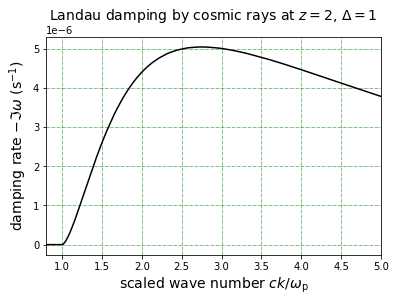

4.6200087839556406e-09 2.0083681725319145


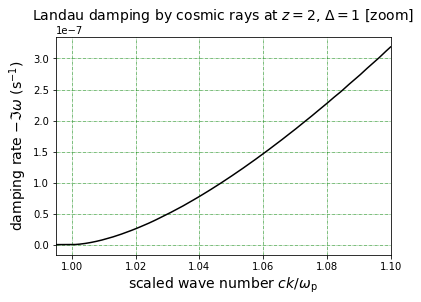

In [4]:
z = 2
omega_p,z_ = compute_properties(z)
print(omega_p/c,z_)
k = omega_p/c * np.linspace(.8,5,1000)
rate = np.zeros((len(k), ))
for i in range(len(k)):
    rate[i] = get_rate(z, k[i])

plt.plot(k/(omega_p/c), -rate, color = 'black')
plt.title('Landau damping by cosmic rays at $z=2$, $\Delta=1$', fontsize = 14)
plt.xlabel('scaled wave number $ck/\omega_{\mathrm{p}}$', fontsize = 14)
plt.ylabel('damping rate $-\Im \omega \ (\mathrm{s^{-1}})$', fontsize = 14)
plt.grid(color = 'green', linestyle = '-.', linewidth = 0.5)
plt.xlim([.8,5])
plt.savefig('growth_rate.pdf')
plt.show()

z = 2
omega_p,z_ = compute_properties(z)
print(omega_p/c,z_)
k = omega_p/c * np.linspace(.995,1.1,1000)
rate = np.zeros((len(k), ))
for i in range(len(k)):
    rate[i] = get_rate(z, k[i])

plt.plot(k/(omega_p/c), -rate, color = 'black')
plt.title('Landau damping by cosmic rays at $z=2$, $\Delta=1$ [zoom]', fontsize = 14)
plt.xlabel('scaled wave number $ck/\omega_{\mathrm{p}}$', fontsize = 14)
plt.ylabel('damping rate $-\Im \omega \ (\mathrm{s^{-1}})$', fontsize = 14)
plt.grid(color = 'green', linestyle = '-.', linewidth = 0.5)
plt.xlim([.995,1.1])
plt.savefig('growth_rate_zoom.pdf')
plt.show()